# Кластеризация

Кластеризация - задача машинного обучения по выделению групп среди множества объектов. У нас нет заданного списка групп, мы пытаемся найти эти группы на основе данных.


Алгоритмы:

- метод K средних (K-means)
- иерархическая кластеризация
- DBSCAN
- спектральная кластеризация


Разные методы подходят под разные задачи. На картинке ниже видно, что на разных наборах данных датасеты по-разному делят их на кластеры, иногда удачно, иногда нет. Это связано с теми принципами, на которых основан алгоритм.
    
*Источник: документация sklearn*
<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png">

## Датасет

В этот раз наоборот, рассмотрим применение алгоритмов на данных попроще, а практику - на текстовых данных.

Поработаем с датасетом про пингвинов, который можно загрузить через библиотеки seaborn

In [1]:
import seaborn as sns
import pandas as pd

Загружаем датасет, убираем данные с пропусками

In [2]:
dataset = sns.load_dataset("penguins")
print(dataset.shape)

dataset = dataset.dropna()
print(dataset.shape)

(344, 7)
(333, 7)


Посмотрим, что внутри:
    
1. Вид (Adelie - пингвины Адели, Chinstrap - антарктический пингвин, Gentoo - субарктический пингвин)
2. Остров (не используем)
3. bill_length_mm - длина клюва
4. bill_depth_mm - глубина/толщина клюва
5. flipper_length_mm - крыла
6. body_mass_g - масса тема
7. sex - самцы / самки

In [3]:
dataset.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


Посмотрим, сколько каких пингвинов в датасете

In [4]:
dataset.groupby(["species", "sex"]).agg({"bill_length_mm": "count"})

bill_length_mm
species   sex                   
Adelie    Female              73
          Male                73
Chinstrap Female              34
          Male                34
Gentoo    Female              58
          Male                61

Посмотрим на распределение показателей

In [5]:
dataset.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057
std,5.468668,1.969235,14.015765,805.215802
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.500000,17.300000,197.000000,4050.000000
75%,48.600000,18.700000,213.000000,4775.000000
max,59.600000,21.500000,231.000000,6300.000000


Так как параметры в разных шкалах, мы должны их стандартизировать

**Стандартизация данных**

In [6]:
from sklearn.preprocessing import StandardScaler

Обучаем scaler на числовых переменных

In [7]:
sc = StandardScaler()
sc.fit(dataset.select_dtypes("number"))

StandardScaler()

Применяем, сохраняем в Х результат, превращаем его из матрицы в датафрейм (для удобства)

In [8]:
X = sc.transform(dataset.select_dtypes("number"))
X = pd.DataFrame(X)
X.columns = dataset.select_dtypes("number").columns

Удостоверимся, что все ок с распределениями (mean = 0, std = 1)

In [9]:
X.describe().round(3)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,333.000,333.000,333.000,333.000
mean,0.000,0.000,0.000,0.000
std,1.002,1.002,1.002,1.002
min,-2.178,-2.067,-2.070,-1.874
25%,-0.823,-0.796,-0.784,-0.817
50%,0.093,0.069,-0.283,-0.195
75%,0.844,0.781,0.860,0.706
max,2.858,2.205,2.146,2.603


## K-means

K-means (метод К средних) основан на вычислении центров кластеров и нахождении “равновесия”, то есть оптимального положения центров.
Центр кластера - это центр масс набора точек, то есть точка, координаты которой равны усредненным координатам всех точек группы.



<img src="https://upload.wikimedia.org/wikipedia/commons/e/ea/K-means_convergence.gif" width=400>

In [11]:
from sklearn.cluster import KMeans

Задаем параметры: кол-во кластеров и закрепляем генератор случайных чисел (первые положения ценров кластеров)

In [12]:
model = KMeans(n_clusters=3, random_state=1)

Обучаем

In [13]:
model.fit(X)

KMeans(n_clusters=3, random_state=1)

Получаем метки кластеров

In [14]:
clusters = model.predict(X)

Посмотрим, какие виды пингвинов в какие кластеры попали (похожа ли логика?)

In [15]:
def clusters_stats(clusters):
    
    # делаем копию датасета и сохраняем метки кластеров туда
    data_with_labels = dataset.copy()
    data_with_labels["cluster"] = clusters
    
    # смотрим сочетания меток видов и кластеров
    data_with_labels["i"] = 1
    print(data_with_labels.pivot_table(index="species", columns="cluster", values="i", aggfunc="sum").fillna(""))
    print("-" * 50)
    
    # смотрим сочетания меток видов + гендер и кластеров
    print(data_with_labels.pivot_table(index=["species", "sex"], columns="cluster", values="i", aggfunc="sum").fillna(""))

In [16]:
clusters_stats(clusters)

cluster        0      1     2
species                      
Adelie     124.0         22.0
Chinstrap    5.0         63.0
Gentoo            119.0      
--------------------------------------------------
cluster              0     1     2
species   sex                     
Adelie    Female  73.0            
          Male    51.0        22.0
Chinstrap Female   5.0        29.0
          Male                34.0
Gentoo    Female        58.0      
          Male          61.0      


В целом видно, что субантарктические пингвины четко отличаются (кластер 1), пингвины Адели и антарктические в целом тоже, но заметим, что самки антарктического и самцы Адели попадают в другой кластер.


Посмотрим на усредненные показатели реальных значений параметров (центры кластеров), обратно превратив их scaler'ом.

In [17]:
real_numbers = sc.inverse_transform(model.cluster_centers_)

pd.DataFrame(real_numbers, columns=X.columns)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,38.276744,18.121705,188.627907,3593.798450
1,47.568067,14.996639,217.235294,5092.436975
2,47.662353,18.748235,196.917647,3898.235294


### Метод локтя

Метод локтя (elbow method) - это метод подбора оптимального кол-ва кластеров.

В чем идея? 

Кластеризация проводится с разным числом кластеров, вычсляется сумма квадратов расстояний от объектов до центра их кластера. Если сумма большая, то объекты в целом далеки от центров, если очень маленькое, то кластеры кучные или просто центров так много, что в целом везде есть маленькие близкие группы.

Выбирается число, где расстояние до центра кластера перестает существенно меняться (кластеры достаточно кучные, но не слишком мелкие).

На графике это место “перелома”, где кривая переходит к пологому участку. Этот изгиб похож на изгиб руки в локте, поэтому этот метод так называется.


In [18]:
import matplotlib.pyplot as plt

Для каждого числа кластеров строим модель, достаем inertia_ - сумма квадратов расстояний от объекта до центра кластера.

In [19]:
distortions = []
cluster_range = range(1, 21)
for k in cluster_range:
    model = KMeans(n_clusters=k)
    model.fit(X)
    distortions.append(model.inertia_)

Визуализируем

Text(0, 0.5, 'Сумма квадратов расстояний')

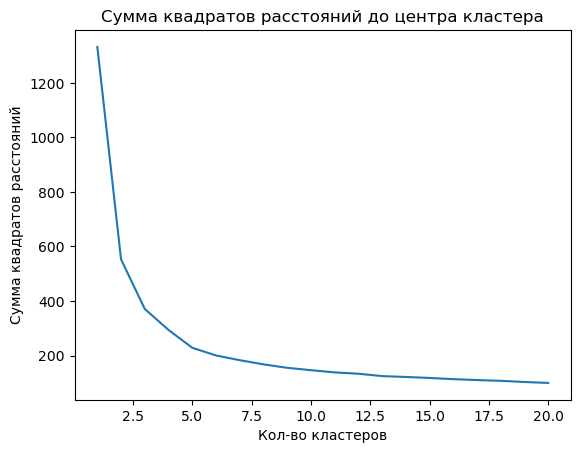

In [20]:
sns.lineplot(x=cluster_range, y=distortions)
plt.title("Сумма квадратов расстояний до центра кластера")
plt.xlabel("Кол-во кластеров")
plt.ylabel("Сумма квадратов расстояний")

Наиболее удачным кажется выбор 3-4 кластеров

## Иерархическая кластеризация

Иерархическая кластеризация - это целое семейство алгоритмов, которые основываются на создании иерархии (дерева) объектов на основе близости между объектами.


N кластеров получается отсечением дерева на каком-то уровне, так что ветви становятся отдельными группами.
Они отличаются:

- по направлению (разделяющие vs объединяющие)
- по типу связи (как рассчитывается расстояние): минимальная, максимальная, средняя и другие

Также выбирается метрика, по которой вычисляется расстояние.



*Источник: [dashee87.github.io](https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/)*

<img src="https://dashee87.github.io/images/hierarch.gif">

*Источник: Википедия*
<div class="row">
    <div class="col-md-6">
        <img src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Hierarchical_clustering_simple_diagram.svg">
    </div>
    <div class="col-md-6">
        <img src="https://upload.wikimedia.org/wikipedia/commons/1/12/Iris_dendrogram.png">
    </div>
</div>



**sklearn**

В sklearn AgglomerativeClustering работает так же, как и другие модели (fit, predict)

In [21]:
from sklearn.cluster import AgglomerativeClustering

In [22]:
model = AgglomerativeClustering(n_clusters=3)

model.fit(X)

AgglomerativeClustering(n_clusters=3)

Применим ту же функцию, что и раньше с K-Means

In [23]:
clusters = model.labels_
clusters_stats(clusters)

cluster        0      1     2
species                      
Adelie            146.0      
Chinstrap          11.0  57.0
Gentoo     119.0             
--------------------------------------------------
cluster              0     1     2
species   sex                     
Adelie    Female        73.0      
          Male          73.0      
Chinstrap Female        11.0  23.0
          Male                34.0
Gentoo    Female  58.0            
          Male    61.0            


Кажется, что более похоже по видам выделяются кластеры.

**scipy**

В scipy тоже есть иерархическая кластеризация, удобно ее визуализировать. Она состоит из 2 этапов

1. Расчеты связей между элементами (задаем метод расчета расстояния и метрику)
2. Построение дерева (дендрограммы) и ее визуализация

In [24]:
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

Чтобы хорошо вмещалось на картинку, возьмем небольшую подвыборку

In [26]:
indices = np.random.choice(dataset.shape[0], size=30)

Считаем связи:
    
1. метод Уорда
2. Эвклидово расстояние

In [33]:
Z = linkage(X.iloc[indices], method='ward', metric="euclidean")
labels=(dataset["species"] + "|" + dataset["sex"]).iloc[indices].tolist()

Визуализируем дендрограмму

1. orientation='right' - слева направо
2. подписи элементов
3. высота, на которой поделим цветом (можно порисовать и выбрать нужную)

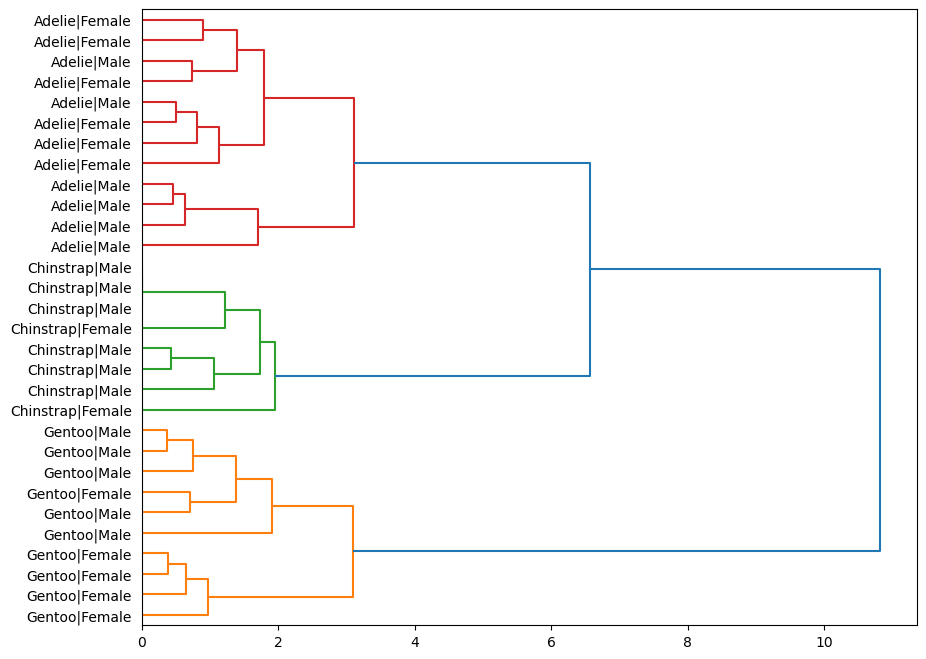

In [34]:
fig = plt.figure(figsize=(10, 8))
dn = dendrogram(Z, orientation='right', labels=labels, color_threshold=5)
plt.show()

## Практика


### Датасет

Поработаем с датасетом с текстами 20newsgroups, как и в прошлый раз. Попробуем посмотреть, какие группы текстов можно выделить и как они соответствуют реально выделенным.


In [44]:
from sklearn.datasets import fetch_20newsgroups

In [45]:
dataset = fetch_20newsgroups()

In [47]:
dataset.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [48]:
target_names = dataset["target_names"]

dataset = pd.DataFrame({"text": dataset["data"], "label": dataset["target"]})

Можно сделать подвыборку текстов (500 или 1000), чтобы работало быстрее и не ждать долго (например, подбор кластеров). А потом сделать на полном датасете (так будет показательнее)

In [ ]:
# dataset = dataset.sample(500)

In [50]:
dataset.head()

,text,label
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


### Подготовка данных


Создайте X - векторизованную версию текстов с помощью TF-IDF. Ограничьте количество признаков (слов), например 1000 или 10000.

In [ ]:
# импортируем TF-IDF



In [ ]:
# задаем параметры (добавим стоп-слова)



In [ ]:
# обучаем TF-IDF



In [ ]:
# преобразуем тексты и сохраняем в паременную Х



### Кластеризуем тексты

### K-means: подбираем число кластеров и кластеризуем

1. Метод локтя. Для метода локтя здесь можно попробовать более большое число кластеров (так как тут много тем текстов).  **Может занять время, пока работает, можно писать код под следующие этапы**
2. Кластеризуем на выбранное число кластеров
3. Смотрим, какие категории текстов (из меток датасета) в какие кластеры попадает 

In [ ]:
# примените метод локтя (см. код выше)





In [ ]:
# создаем модель и задаем параметры K-means



In [ ]:
# обучаем



In [ ]:
# сохраняем предсказания в датафрейм



Обычно **нет** меток, с которыми можно сравнить, у нас это учебный пример, чтобы посмотреть, какие данные могут объединяться в кластеры

In [ ]:
# смотрим, какие кластеры и метки текстов встречаются вместе



**Ключевые слова для кластеров (примерный код)**

1. Сортируем слова внутри кластеров (их порядковые номера от важных (большой tf-idf) к менее важным (маленький tf-idf)
2. Получаем список слов (чтобы по ранее полученным индексам к ним обращаться)
3. Идем по числу кластеров (задать) и для каждого печатаем 10 первых (важных) слов: берем его индекс и из списка достаем слово

In [ ]:
# model - обученная модель kmeans
# tfidf - tfidf модель
# n_clusters - число кластеров

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()

for i in range(n_clusters):
    top_10 = [terms[ind] for ind in order_centroids[i, :10]]
    print("Кластер {}: {}".format(i, ' '.join(top_10)))

### Иерархическая кластеризация